# Testing PyBSE with bare-bones binary code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell, norm, uniform, powerlaw, truncnorm
from scipy.interpolate import interp1d
import os
import glob
import pybse
import time

%matplotlib inline

In [2]:
G = 6.674e-8 # Gravitational constant in cgs
GGG = 1.909e5 # Gravitational constant in Rsun * (km/s)^2 / Msun
km_to_cm = 1.0e5 # km to cm
Msun_to_g = 1.989e33 # Msun to g
Rsun_to_cm = 6.995e10 # Rsun to cm
AU_to_cm = 1.496e13 # AU to cm
pc_to_cm = 3.086e18 # parsec to cm
pc_to_km = 3.086e13 # parsec to km
yr_to_sec = 31557600.0 # Sec in yr
asec_to_rad = 4.84814e-6 # Arcsec to radians

M_0 = 0.073 # in Msun
xi = 0.704
M_NS = 1.44
#v_wind = 1000.0 # companion velocity in km/s
R_NS = 12.0  # NS radius in km
min_mass = 6.0
max_mass = 39.0

### Define population synthesis functions

In [3]:
# Define random deviate functions

def get_v_k(sigma, N):
    return maxwell.rvs(scale = sigma, size = N)

def get_theta(N):
    return np.arccos(1.0-2.0*uniform.rvs(size = N))

def get_phi(N):
    return 2.0*np.pi*uniform.rvs(size = N)

def get_M1(x1, x2, alpha, N):

    A = (alpha+1.0) / (np.power(x2, alpha+1.0) - np.power(x1, alpha+1.0))
    x = uniform.rvs(size = N)
    
    return np.power(x*(alpha+1.0)/A + np.power(x1, alpha+1.0), 1.0/(alpha+1.0))
    
# Mass ratio - uniform [0.3,1.0]
def get_q(N):
    return 0.7 * uniform.rvs(size = N) + 0.3 
    
def get_A(a1, a2, N):
    
    x1 = np.log10(a1)
    x2 = np.log10(a2)
    
    return np.power(10.0, (x2-x1)*uniform.rvs(size=N) + x1)

def get_ecc(N):
    return np.sqrt(uniform.rvs(size=N))

def P_to_A(M1, M2, P):
    mu = G * (M1 + M2) * Msun_to_g
    n = 2.0*np.pi / P / yr_to_sec
    A = np.power(mu/(n*n), 1.0/3.0) / AU_to_cm
    return A
    
def A_to_P(M1, M2, A):
    mu = G * (M1 + M2) * Msun_to_g
    n = np.sqrt(mu/(A**3 * AU_to_cm**3))
    P = 2.0*np.pi / n
    return P / yr_to_sec



In [4]:
n_bin = 1000
M1_i = get_M1(8.0, 40.0, -2.35, n_bin)
M2_i = M1_i * get_q(n_bin)
A_i = get_A(1.0e0, 1.0e3, n_bin)
p_orb_i = A_to_P(M1_i, M2_i, A_i) * 365.25
ecc_i = get_ecc(n_bin)
v_kick = get_v_k(265.0, n_bin)
theta_kick = get_theta(n_bin)
phi_kick = get_phi(n_bin)
tmax = 50.0
z=0.008


In [5]:
#print pybse.evolv_wrapper(n_bin, M1_i, M2_i, p_orb, ecc, v_kick, theta_kick, phi_kick, tmax, z) 

start_time = time.time()

Macc_out = np.array([])
M1_out = np.array([])
M2_out = np.array([])
ecc_out = np.array([])
a_out = np.array([])


for i in np.arange(n_bin):
#    print "In:", M1_i[i], M2_i[i], p_orb_i[i], A_i[i], ecc_i[i], v_kick[i], theta_kick[i], phi_kick[i]
    var_out = pybse.evolv_wrapper(1, M1_i[i], M2_i[i], p_orb_i[i], ecc_i[i], v_kick[i], theta_kick[i], \
                                  phi_kick[i], tmax, z, False)
        
    if var_out[0]>0.0 and var_out[1]>0.0 and var_out[2]>0.0 and var_out[4]!=15 and var_out[5]!=15 and \
        (var_out[6]>0.0 or var_out[7]>0.0) and \
        (var_out[4]==13 or var_out[4]==14 or var_out[5]==13 or var_out[5]==14):
        
        Macc_out = np.append(Macc_out, var_out[6])
        M1_out = np.append(M1_out, var_out[0])
        M2_out = np.append(M2_out, var_out[1])
        a_out = np.append(a_out, var_out[2])
        ecc_out = np.append(ecc_out, var_out[3])
        
    
print "Ran", n_bin, "binaries in", time.time()-start_time, "seconds"
# NOTE: Orbital separation output is in Rsun

print len(Macc_out)


Ran 1000 binaries in 4.27301216125 seconds
0


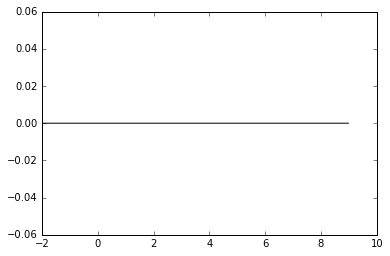

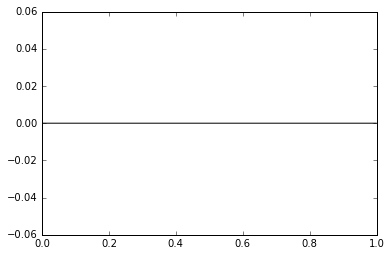

In [6]:
plt.hist(np.log10(a_out), range=[-2, 9], bins=30, histtype='step', color='k')
plt.show()
plt.hist(np.log10(Macc_out[np.where(Macc_out>0.0)]), bins=30, histtype='step', color='k')
plt.show()

### Load SSE data

In [7]:
names = ["time","type","mass","mdot","radius"]

f_list = glob.glob("../../data/sse_data/mdot_*.dat")

f_list = np.sort(f_list)

# Create empty data storage structure
sse_data = np.recarray(0, names=names, formats=['f8,float64,float64'])

func_sse_mdot = np.array([])
func_sse_mass = np.array([])
func_sse_radius = np.array([])
sse_tmp_mass = np.array([])
sse_tmp_time = np.array([])
sse_tmp_radius = np.array([])
sse_tmp_MS_radius = np.array([])
sse_tmp_ZAMS_radius = np.array([])

for f in f_list:
    datafile = os.path.abspath(f)
#    sse_tmp_data = np.genfromtxt(datafile, usecols=(0,2,3,4), dtype="f8,float64,float64,float64", skip_header=1, names=names)
    sse_tmp_data = np.genfromtxt(datafile, dtype="f8,int,float64,float64,float64", skip_header=1, names=names)
    
#    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=0.0))    
#    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_mass = np.append(func_sse_mass, interp1d(sse_tmp_data["time"], sse_tmp_data["mass"], bounds_error=False, fill_value=sse_tmp_data["mass"][-1]))    
    func_sse_mdot = np.append(func_sse_mdot, interp1d(sse_tmp_data["time"], sse_tmp_data["mdot"], bounds_error=False, fill_value=0.0))
    func_sse_radius = np.append(func_sse_radius, interp1d(sse_tmp_data["time"], sse_tmp_data["radius"], bounds_error=False, fill_value=0.0))
    
    sse_tmp_time = np.append(sse_tmp_time, max(sse_tmp_data["time"])-1.0)
    sse_tmp_mass = np.append(sse_tmp_mass, sse_tmp_data["mass"][0])
    sse_tmp_ZAMS_radius = np.append(sse_tmp_ZAMS_radius, sse_tmp_data["radius"][0])
    sse_tmp_radius = np.append(sse_tmp_radius, max(sse_tmp_data["radius"]))
    sse_tmp_MS_radius = np.append(sse_tmp_MS_radius, max(sse_tmp_data["radius"][np.where(sse_tmp_data["type"]==1)]))

# Lifetime function
func_sse_tmax = interp1d(sse_tmp_mass, sse_tmp_time, bounds_error=False, fill_value=0.0)
func_sse_min_mass = interp1d(sse_tmp_time, sse_tmp_mass, bounds_error=False, fill_value=1.0)
func_sse_r_ZAMS = interp1d(sse_tmp_mass, sse_tmp_ZAMS_radius, bounds_error=False, fill_value=0.0)
func_sse_rmax = interp1d(sse_tmp_mass, sse_tmp_radius, bounds_error=False, fill_value=0.0)
func_sse_r_MS_max = interp1d(sse_tmp_mass, sse_tmp_MS_radius, bounds_error=False, fill_value=0.0)

In [8]:
def func_get_sse_star(mass, time):

    mass_out = np.array([])
    mdot_out = np.array([])
    radius_out = np.array([])

    if isinstance(mass, np.ndarray):
        
        if len(mass) == 1:
            mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
            mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))        
            radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
        else:
            for i in np.arange(len(mass)):
                if (int(mass[i]*100.0)-100<0 or int(mass[i]*100.0)-100>len(func_sse_mass)): continue
                mass_out = np.append(mass_out, func_sse_mass[int(mass[i]*100.0)-100](time[i]))
                mdot_out = np.append(mdot_out, func_sse_mdot[int(mass[i]*100.0)-100](time[i]))
                radius_out = np.append(radius_out, func_sse_radius[int(mass[i]*100.0)-100](time[i]))
    else:
        mass_out = np.append(mass_out, func_sse_mass[int(mass*100.0)-100](time))
        mdot_out = np.append(mdot_out, func_sse_mdot[int(mass*100.0)-100](time))
        radius_out = np.append(radius_out, func_sse_radius[int(mass*100.0)-100](time))
            
    return mass_out, mdot_out, radius_out
    

In [9]:
names = ["mass","he_mass","t_ms"]
f = "../../data/sse_data/He_star.dat"

sse_he_star = np.genfromtxt(os.path.abspath(f), usecols=(0,1,2), names=names)

func_sse_he_mass = interp1d(sse_he_star["mass"], sse_he_star["he_mass"], bounds_error=False, fill_value=0.001)
func_sse_ms_time = interp1d(sse_he_star["mass"], sse_he_star["t_ms"], bounds_error=False, fill_value=-1.0e10)

In [10]:
# To Do: Check for thermal timescale MT criterion

def func_MT_forward(M_1_in, M_2_in, A_in, ecc_in):

#    M_1_out = M_0 * M_1_in**(1./xi)
    M_1_out = func_sse_he_mass(M_1_in)
#    M_1_out = 3.7
    M_2_out = M_1_in + M_2_in - M_1_out    
    A_out = A_in * (1.0-ecc_in) * (M_1_in*M_2_in/M_1_out/M_2_out)**2
        
    # Make sure systems don't overfill their Roche lobes
#    r_1_max = func_sse_rmax(M_1_out)
    r_1_max = func_sse_r_MS_max(M_1_out)
    r_1_roche = func_Roche_radius(M_1_in, M_2_in, A_in)
#    r_2_max = func_sse_rmax(M_2_out)
    r_2_max = func_sse_r_MS_max(M_2_out)
    r_2_roche = func_Roche_radius(M_2_in, M_1_in, A_in)
        
    if isinstance(A_out, np.ndarray):
        A_out[np.where(r_1_max > r_1_roche)] = -1.0
        A_out[np.where(r_2_max > r_2_roche)] = -1.0
    else:
        if r_1_max > r_1_roche or r_2_max > r_2_roche: A_out = -1.0
    
    return M_1_out, M_2_out, A_out
    
def func_MT_backward(M_1_in, M_2_in, A_in):
    
    M_1_out = (M_1_in/M_0)**xi
    M_2_out = M_2_in - M_1_out + M_1_in
    A_out = A_in * (M_1_in*M_2_in/M_1_out/M_2_out)*(M_1_in*M_2_in/M_1_out/M_2_out)

    return M_1_out, M_2_out, A_out


def func_Roche_radius(M1, M2, A):
    q = M1 / M2
    return A * 0.49*q**(2.0/3.0) / (0.6*q**(2.0/3.0) + np.log(1.0 + q**(1.0/3.0)))

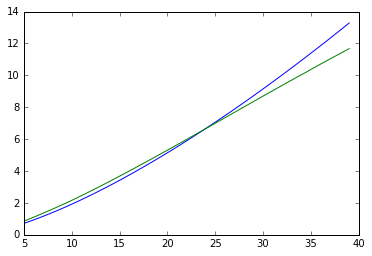

In [11]:
M1 = np.linspace(5.0, 39.0, 100)
M1_core_approx = M_1_out = M_0 * M1**(1./xi)
M1_core_sse = func_sse_he_mass(M1)

plt.plot(M1, M1_core_approx)
plt.plot(M1, M1_core_sse)
    
plt.show()

In [12]:
def func_SN_forward(M_1_in, M_2, A_in, v_k, theta, phi):
    if isinstance(A_in, np.ndarray):
        A_in[np.where(A_in<=0.0)] = 1.0e-50
    else:
        if A_in<=0.0: A_in = 1.0e-50

    v_r = np.sqrt(GGG*(M_1_in + M_2)/A_in)
    v_1 = np.sqrt(2.0*v_k*v_r*np.cos(theta) + v_k*v_k + v_r*v_r)
    
    A_out = 1.0 / (2.0/A_in - v_1*v_1/(GGG*(M_NS+M_2)))
#    v_sys = (M_NS / (M_NS + M_2)) * v_1
    
    # Systemic velocity    
    alpha = (M_1_in / (M_1_in + M_2))    
    beta = (M_NS / (M_NS + M_2))
    
    v_sys = beta*beta*v_k*v_k
    v_sys = v_sys + v_r*v_r*(beta-alpha)*(beta-alpha)
    v_sys = v_sys + 2.0*beta*v_k*v_r*np.cos(theta)*(beta-alpha)
    v_sys = np.sqrt(v_sys)
    
    # Eccentricity
    e_tmp = v_k*v_k*np.cos(theta)*np.cos(theta) 
    e_tmp = e_tmp + v_k*v_k*np.sin(theta)*np.sin(theta)*np.sin(phi)*np.sin(phi) 
    e_tmp = e_tmp + 2.0*v_k*v_r*np.cos(theta)
    e_tmp = e_tmp + v_r*v_r
    e_tmp = 1.0 - (A_in*A_in)/(A_out*GGG*(M_NS+M_2)) * e_tmp
        
    if isinstance(e_tmp, np.ndarray):
        
        ecc = np.sqrt(e_tmp)
        ecc[np.where(e_tmp < 0.0)] = -1.0
        ecc[np.where(e_tmp > 1.0)] = -1.0
        ecc[np.where(M_2 < min_mass)] = -1.0
        ecc[np.where(A_in < 1.0e-10)] = -1.0
#        ecc = np.array([np.sqrt(x) if x > 0.0 or M_2 > min_mass or A_in>1.0e-10 else -1.0 for x in e_tmp])
    else:
        if e_tmp < 0.0 or M_2 < min_mass or A_in < 1.0e-10: return A_out, v_sys, -1.0
        ecc = np.sqrt(e_tmp)
    
    return A_out, v_sys, ecc



In [13]:
# To Do: What happens when companion's lifetime falls between primary's MS lifetime and stellar lifetime?
# To Do: Remove RLOF systems

def func_get_time(M1, M2, t_obs):

    t_lifetime_1 = func_sse_ms_time(M1)
    he_mass_1 = func_sse_he_mass(M1)
    
    t_lifetime_2 = func_sse_ms_time(M2)
    he_mass_2 = func_sse_he_mass(M2)
    
    # Relative lifetime through star 2 at mass gain
    he_mass = t_lifetime_1/t_lifetime_2 * he_mass_2
    
    # Get new secondary parameters
    mass_new = M2 + M1 - he_mass_1
    t_lifetime_new = func_sse_ms_time(mass_new)
    he_mass_new = func_sse_he_mass(mass_new)

    # New, effective lifetime
    t_eff = he_mass / he_mass_new * t_lifetime_new
    
    # Now, we obtain the "effective observed time"
    return t_eff + t_obs - t_lifetime_1
         
    
    
def get_v_wind(mass, radius):
    
    slope = (7.0 - 0.5) / (120.0 - 1.4)
    intercept = 7.0 - 120.0 * slope
    
    beta = slope * mass + intercept
    
    # TEST
    beta = 0.125
    # TEST
    
    # For systems with radius = 0.0, set wind arbitrarily high
    if isinstance(radius, np.ndarray):
        one_over_radius = 1.0e50 * np.ones(len(radius))
        one_over_radius[np.where(radius>0.0)] = 1.0 / radius[np.where(radius>0.0)]
    else:
        one_over_radius = 1.0e50
        if radius>0.0: one_over_radius = 1.0/radius
    
    return np.sqrt(2.0 * beta * GGG * mass * one_over_radius)
    
    
    
def func_Lx_forward(M_1_a, M_2_a, M_2_in, A_in, ecc_in, t_obs):
    
    t_eff_obs = func_get_time(M_1_a, M_2_a, t_obs)
    
    if isinstance(t_eff_obs, np.ndarray):
        M_2_out = np.array([])
        M_dot_wind = np.array([])
        R_out = np.array([])
        for i in np.arange(len(t_eff_obs)):
            if (t_eff_obs[i] < 0.0 or ecc_in[i] < 0.0 or ecc_in[i] >= 1.0): 
                ecc_in[i] = 0.0
                if isinstance(M_2_in, np.ndarray):
                    M_2_out = np.append(M_2_out, M_2_in[i])
                else:
                    M_2_out = np.append(M_2_out, M_2_in)
                M_dot_wind = np.append(M_dot_wind, 0.0)
                R_out = np.append(R_out, 0.0)
            else:
                if isinstance(M_2_in, np.ndarray):
                    if M_2_in[i] > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in[i], t_eff_obs[i])
                else:
                    if M_2_in > max_mass: 
                        a, b, c = 0.0, 0.0, 0.0
                    else:
                        a, b, c = func_get_sse_star(M_2_in, t_eff_obs[i])

                M_2_out = np.append(M_2_out, a)
                M_dot_wind = np.append(M_dot_wind, b)    
                R_out = np.append(R_out, c)
    else:
        if (t_eff_obs < 0.0 or M_2_in > max_mass or ecc_in < 0.0 or ecc_in > 1.0): 
            M_2_out = M_2_in
            M_dot_wind = 0.0
            R_out = 0.0
            ecc_in = 0.0
        else:
            M_2_out, M_dot_wind, R_out = func_get_sse_star(M_2_in, t_eff_obs)

          
    # Get wind velocity
    v_wind = get_v_wind(M_2_out, R_out)
    if isinstance(v_wind, np.ndarray):
        v_wind[np.where(v_wind <= 0.0)] = 1.0e50 # To eliminate "bad" winds
    else:
        if v_wind <= 0.0: v_wind = 1.0e50
    
    # Get final orbital separation
    if isinstance(A_in, np.ndarray):
        A_in[np.where(A_in <= 0.0)] = 1.0e50 # To eliminate "bad" separations
    else:
        if A_in <= 0.0: A_in = 1.0e50
    A_out = (M_NS + M_2_in) / (M_NS + M_2_out) * A_in
    
    # Capture fraction takes into account eccentricity
    f_capture = (GGG*M_NS / (v_wind*v_wind*A_out))**2 / np.sqrt(1.0 - ecc_in**2)
    M_dot_out = f_capture * M_dot_wind
        
    L_bol = GGG * M_NS * M_dot_out / R_NS * km_to_cm * Msun_to_g * Rsun_to_cm / yr_to_sec
    L_x = L_bol
    
#    print v_wind, R_out, M_2_in, t_eff_obs
        
    
    return M_2_out, L_x, M_dot_out, A_out
    

In [14]:
print func_MT_forward(13.7, 12.8, 754.0, 0.0)

(array(3.27144623), 23.228553770000001, 4015.2122177691213)


In [15]:
def full_forward(M1, M2, A, ecc, v_k, theta, phi, t_obs):

    # Star does not make it to MT phase
    if t_obs < func_sse_ms_time(M1): return M1, M2, 0.0, 0.0, 0.0, A
        
    # MT phase
    M_1_b, M_2_b, A_b = func_MT_forward(M1, M2, A, ecc)
        
    # Star does not make it to SN
    if t_obs < func_sse_tmax(M1): return M_1_b, M_2_b, 0.0, 0.0, 0.0, A_b
    
    # SN
    A_tmp, v_sys_tmp, e_tmp = func_SN_forward(M_1_b, M_2_b, A_b, v_k, theta, phi)
                       
    # XRB
    M_2_tmp, L_x_tmp, M2_dot_out, A_out = func_Lx_forward(M1, M2, M_2_b, A_tmp, e_tmp, t_obs)

    return M_NS, M_2_tmp, L_x_tmp, v_sys_tmp, M2_dot_out, A_out

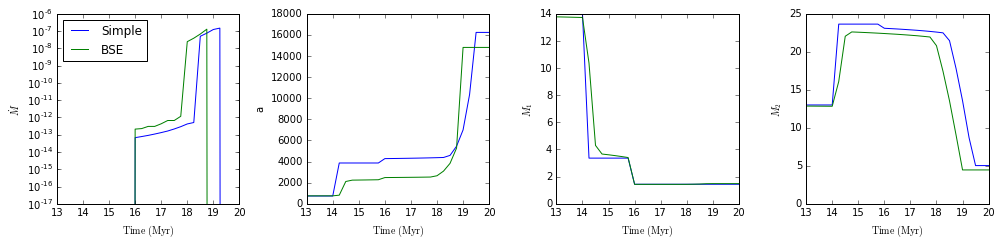

In [16]:
fig = plt.figure(figsize=(14, 3.5))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)


M1_test = 14.0
M2_test = 13.0
A_test = 738.0
P_orb_test = A_to_P(M1_test, M2_test, A_test*Rsun_to_cm/AU_to_cm) * 365.25
ecc_test = 0.0
v_k_test = 0.0
theta_test = 3.0
phi_test = 1.0
tmax = 30.0
z = 0.02

# print P_orb_test

aout_simple = np.array([])
mdot_simple = np.array([])
m1_simple = np.array([])
m2_simple = np.array([])

aout_bse = np.array([])
mdot_bse = np.array([])
m1_bse = np.array([])
m2_bse = np.array([])

test_times = np.linspace(13.0, 20.0, 29) 

for tmax in test_times:
    temp_out = full_forward(M1_test, M2_test, A_test, ecc_test, v_k_test, theta_test, phi_test, tmax)
        
    if isinstance(temp_out[2], np.ndarray):
        aout_simple = np.append(aout_simple, temp_out[5][0])
    else:
        aout_simple = np.append(aout_simple, temp_out[5])
        
    
    if isinstance(temp_out[3], np.ndarray): 
        mdot_simple = np.append(mdot_simple, temp_out[4][0])
        m1_simple = np.append(m1_simple, temp_out[0][0])
        m2_simple = np.append(m2_simple, temp_out[1][0])
    else:
        mdot_simple = np.append(mdot_simple, temp_out[4])
        m1_simple = np.append(m1_simple, temp_out[0])
        m2_simple = np.append(m2_simple, temp_out[1])
        
    var_out = pybse.evolv_wrapper(1, M1_test, M2_test, P_orb_test, ecc_test, v_k_test, theta_test, \
                                  phi_test, tmax, z, True)
    mdot_bse = np.append(mdot_bse, var_out[6])
    aout_bse = np.append(aout_bse, var_out[2])
    m1_bse = np.append(m1_bse, var_out[0])
    m2_bse = np.append(m2_bse, var_out[1])
#    if var_out[6] != 0.0: print tmax, var_out
        
    
ax1.plot(test_times, mdot_simple, label='Simple')
ax1.plot(test_times, mdot_bse, label='BSE')
ax1.set_xlabel(r"${\rm Time\ (Myr)}$")
ax1.set_ylabel(r"$\dot{M}$")
#print "Simple version Mdot out:", simple_out[3][0]

ax1.set_yscale('log')
ax1.set_ylim(1.0e-17, 1.0e-6)



#for i in np.arange(len(test_times)):
#    t = test_times[i]
#    print t, aout_bse[i], aout_simple[i]

ax2.plot(test_times, aout_simple)
ax2.plot(test_times, aout_bse)    
ax2.set_xlabel(r"${\rm Time\ (Myr)}$")
ax2.set_ylabel(r"a")

ax3.plot(test_times, m1_simple)
ax3.plot(test_times, m1_bse)
ax3.set_xlabel(r"${\rm Time\ (Myr)}$")
ax3.set_ylabel(r"$M_1$")

ax4.plot(test_times, m2_simple)
ax4.plot(test_times, m2_bse)
ax4.set_xlabel(r"${\rm Time\ (Myr)}$")
ax4.set_ylabel(r"$M_2$")

ax1.legend(loc=2)

plt.tight_layout()


plt.show()
#plt.savefig("test_J_BSE_prescription.pdf")
#plt.savefig("test_J_conserved.pdf")
#print var_out[6]

In [17]:
#2.8e6 * 0.2 * 14.0 / 27.0
J_orb_tot_i = (2.8e6 * 13.7*12.8) / (13.7+12.8)
J_orb_tot_f = (5.48e6 * 3.85*22.46) / (3.85+22.46)
J_lost_naive1 = 2.8e6 * 0.22 * (13.7/26.5)**2 
J_lost_naive2 = 5.48e6 * 0.22 * (22.46/26.31)**2

print "J_orb init:", J_orb_tot_i
print "J_orb final:", J_orb_tot_f
print "J_orb lost:", J_orb_tot_f - J_orb_tot_i
print "Naive lost (star 1):", J_lost_naive1
print "Naive lost (star 2):", J_lost_naive2

J_orb init: 18528603.7736
J_orb final: 18010683.3903
J_orb lost: -517920.383239
Naive lost (star 1): 164638.006408
Naive lost (star 2): 878579.462338


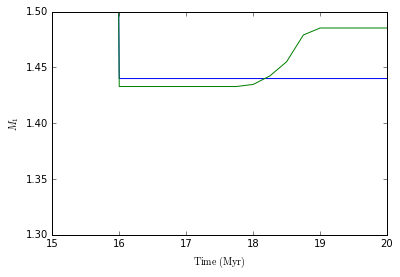

In [18]:
plt.plot(test_times, m1_simple)
plt.plot(test_times, m1_bse)
plt.xlabel(r"${\rm Time\ (Myr)}$")
plt.ylabel(r"$M_1$")
plt.xlim(15.0, 20.0)
plt.ylim(1.3, 1.5)

plt.show()

In [28]:
print aout_simple[-1], aout_bse[-1]
print m1_simple[-1], m1_bse[-1]
print m2_simple[-1], m2_bse[-1]


print (m1_simple[-1]+m2_simple[-1])*aout_simple[-1]/(m1_simple[-1] + 4.388)

16232.5105871 21413.7050781
1.44 1.47504985332
5.02676916 4.3877325058
18011.6504554


### CV test

In [ ]:
n_bin = 1
M1_i = 6.0
M2_i = 1.3
p_orb = 630.0 # in days
ecc = 0.0
v_kick = 2.0
theta_kick = 1.2
phi_kick = 0.1
tmax = 500
z = 0.02

m1_out, m2_out, a_out, ecc_out, k1_out, k2_out, mdot1_out, mdot2_out = pybse.evolv_wrapper(n_bin, M1_i, \
                                                M2_i, p_orb, ecc, v_kick, theta_kick, phi_kick, tmax, z, False) 

print m1_out, m2_out, a_out, ecc_out, k1_out, k2_out, mdot1_out, mdot2_out


In [ ]:
print P_to_A(0.8,0.85,8.5/24.0/365.25) * AU_to_cm * 2.0 * np.pi / (8.5*3600.0) / 1.0e5

In [45]:
mass = 10.0 * Msun_to_g
v_wind = 100.0 * 1.0e5
mass_dot = 1.0e-8 * Msun_to_g / yr_to_sec
rad = 10.0 * AU_to_cm

print mass, v_wind, mass_dot, rad

R_a = 2.0 * G * mass / v_wind**2
rho_0 = mass_dot / v_wind / (4.0*np.pi*rad**2)
print R_a/AU_to_cm, rho_0

L_df = np.pi*R_a**2*rho_0*v_wind**3

print "Orbital Energy:", -G*mass**2/(2.0*rad)
print "Energy decay rate:", L_df

1.989e+34 10000000.0 6.30276066621e+17 1.496e+14
1.77467727273 2.24108209046e-19
Orbital Energy: -8.82458273864e+46
Energy decay rate: 4.96260375553e+29
